In [18]:
import numpy as np
import pandas as pd
import scipy.io
import os
from scipy.signal import savgol_filter
from dtaidistance import dtw
import seaborn as sns
from sklearn import preprocessing
from numpy import inf
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from matplotlib import pyplot as plt
import scipy.spatial.distance as ssd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

In [19]:
#load_path = 'D:\EECE499\Features\\'
load_path = '..\..\..\\'

In [20]:
Features = pd.read_excel(load_path + 'Features.xlsx')

In [21]:
Ratings = pd.read_excel(load_path + 'Ratings.xlsx')

In [22]:
presentations_ids = Features['presentation_id'].values
presentations_ids.shape

(603,)

In [23]:
indices_dict = []
series_gsr = []
series_neuro_sky = []
series_attention = []
series_meditation = []
series_alpha = []
series_beta = []
series_delta = []
series_gamma = []
series_theta = []

for i, presentation_id in enumerate(presentations_ids):
    print(presentation_id, end='\r')
    
    indices_dict.append(presentation_id)
    
    clip_id = presentation_id % 100
    user_id = int(presentation_id / 100)
    
    #data_path = './../../ASCERTAIN_Raw/GSRData/Movie_P' + str(user_id).zfill(2) + '/GSR_Clip' + str(clip_id) + '.mat'
    data_path = 'D:/EECE499/Raw/MyECGFunc/ASCERTAIN_Raw/GSRData/Movie_P' + str(user_id).zfill(2) + '/GSR_Clip' + str(clip_id) + '.mat'
    
    if os.path.isfile(data_path):
        
        signal = scipy.io.loadmat(data_path)
        resistance = signal['Data_GSR'][:,4]
        
        resistance = savgol_filter(resistance, 501, 3)
        series_gsr.append(resistance)
    
    data_path = 'D:/EECE499/Raw/MyECGFunc/ASCERTAIN_Raw/EEGData/Movie_P' + str(user_id).zfill(2) + '/EEG_Clip' + str(clip_id) + '.mat'
    
    if os.path.isfile(data_path):
        
        signal = scipy.io.loadmat(data_path)
        
        neuro_sky_EEG_raw = np.array(signal['ThisEEG'][0])
        attention_raw = np.array(signal['ThisEEG'][1])
        meditation_raw = np.array(signal['ThisEEG'][2])
        alpha_raw = np.array(signal['ThisEEG'][3])
        beta_raw = np.array(signal['ThisEEG'][4])
        delta_raw = np.array(signal['ThisEEG'][5])
        gamma_raw = np.array(signal['ThisEEG'][6])
        theta_raw = np.array(signal['ThisEEG'][7])
        
        window = 51 #101
        order = 4 #3
        try:
            neuro_sky_EEG_raw = savgol_filter(neuro_sky_EEG_raw, window, order)
            attention_raw = savgol_filter(attention_raw, window, order)
            meditation_raw = savgol_filter(meditation_raw, window, order)
            alpha_raw = savgol_filter(alpha_raw, window, order)
            beta_raw = savgol_filter(beta_raw, window, order)
            delta_raw = savgol_filter(delta_raw, window, order)
            gamma_raw = savgol_filter(gamma_raw, window, order)
            theta_raw = savgol_filter(theta_raw, window, order)
        except:
            l = len(neuro_sky_EEG_raw)
            neuro_sky_EEG_raw = np.zeros(l)
            attention_raw = np.zeros(l)
            meditation_raw = np.zeros(l)
            alpha_raw = np.zeros(l)
            beta_raw = np.zeros(l)
            delta_raw = np.zeros(l)
            gamma_raw = np.zeros(l)
            theta_raw = np.zeros(l)
        
        series_neuro_sky.append(neuro_sky_EEG_raw)
        series_attention.append(attention_raw)
        series_meditation.append(meditation_raw)
        series_alpha.append(alpha_raw)
        series_beta.append(beta_raw)
        series_delta.append(delta_raw)
        series_gamma.append(gamma_raw)
        series_theta.append(theta_raw)

In [24]:
dm_gsr = np.load('dist_matrix.npy')
dm_attention = np.load('dm_attention.npy')
dm_neuro_sky = np.load('dm_neuro_sky.npy')
dm_meditation = np.load('dm_meditation.npy')
dm_alpha = np.load('dm_alpha.npy')
dm_beta = np.load('dm_beta.npy')
dm_delta = np.load('dm_delta.npy')
dm_gamma = np.load('dm_gamma.npy')
dm_theta = np.load('dm_theta.npy')

In [25]:
def reformat_matrix(dm):
    i_lower = np.tril_indices(dm.shape[0], -1)
    dm[i_lower] = dm.T[i_lower]
    np.fill_diagonal(dm, 0)
    return dm

In [26]:
dm_gsr = reformat_matrix(dm_gsr)
dm_attention = reformat_matrix(dm_attention)
dm_neuro_sky = reformat_matrix(dm_neuro_sky)
dm_meditation = reformat_matrix(dm_meditation)
dm_alpha = reformat_matrix(dm_alpha)
dm_beta = reformat_matrix(dm_beta)
dm_delta = reformat_matrix(dm_delta)
dm_gamma = reformat_matrix(dm_gamma)
dm_theta = reformat_matrix(dm_theta)

In [27]:
dist_matrix_gsr = dm_gsr
dist_matrix_eeg = dm_attention + dm_neuro_sky + dm_meditation + dm_alpha + dm_beta + dm_delta + dm_gamma + dm_theta
dist_matrix_gsr = dist_matrix_gsr + dist_matrix_eeg

In [28]:
dist_array_gsr = ssd.squareform(dist_matrix_gsr)
dist_array_eeg = ssd.squareform(dist_matrix_eeg)

In [29]:
def get_index(x):
    return indices_dict.index(x)

def dist_gsr(x1, x2):
    i1 = get_index(x1)
    i2 = get_index(x2)
    return dist_matrix_gsr[i1, i2]

def dist_eeg(x1, x2):
    i1 = get_index(x1)
    i2 = get_index(x2)
    return dist_matrix_eeg[i1, i2]

In [30]:
y = []
for c in indices_dict:
    y.append(Ratings.iloc[(Ratings.presentation_id == c).values]['valence'].values[0])

In [31]:
X = np.array(indices_dict).reshape(603, 1)

In [32]:
classifier = KNeighborsClassifier(n_neighbors=5, metric=dist_gsr, algorithm='brute')
classifier

KNeighborsClassifier(algorithm='brute', leaf_size=30,
           metric=<function dist_gsr at 0x000001D6242BAF28>,
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [33]:
limit = 300
X_new = X[limit:limit+100]
y_ = y[limit:limit+100] 
X = X[:limit]
y = y[:limit]

In [34]:
result = cross_validate(classifier, X, y, cv=10, verbose=42, return_train_score=True, \
                        scoring=['accuracy', 'neg_mean_absolute_error', 'neg_mean_squared_error'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , accuracy=0.28125, neg_mean_absolute_error=-1.40625, neg_mean_squared_error=-3.40625, total=  22.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.25, neg_mean_absolute_error=-2.0, neg_mean_squared_error=-6.5, total=  26.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.2min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.3125, neg_mean_absolute_error=-1.71875, neg_mean_squared_error=-5.40625, total=  28.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.2min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.15625, neg_mean_absolute_error=-2.46875, neg_mean_squared_error=-8.78125, total=  31.1s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 12.2min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.16129032258064516, neg_mean_absolute_error=-1.8709677419354838, neg_mean_squared_error=-5.935483870967742, total=  33.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.3min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.06666666666666667, neg_mean_absolute_error=-1.8, neg_mean_squared_error=-4.933333333333334, total=  30.1s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 17.4min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.20689655172413793, neg_mean_absolute_error=-2.0689655172413794, neg_mean_squared_error=-6.689655172413793, total=  13.8s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 18.5min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.17857142857142858, neg_mean_absolute_error=-1.8928571428571428, neg_mean_squared_error=-5.821428571428571, total=  12.8s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 19.6min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.18518518518518517, neg_mean_absolute_error=-1.5555555555555556, neg_mean_squared_error=-3.4814814814814814, total=  16.3s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 20.7min remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.18518518518518517, neg_mean_absolute_error=-1.8148148148148149, neg_mean_squared_error=-5.222222222222222, total=  12.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 21.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 21.6min finished


In [35]:
print(result['train_accuracy'].mean(), result['test_accuracy'].mean())
print(-result['train_neg_mean_absolute_error'].mean(), -result['test_neg_mean_absolute_error'].mean())
print(np.sqrt(-result['train_neg_mean_squared_error'].mean()), np.sqrt(-result['test_neg_mean_squared_error'].mean()))

0.49225075674653834 0.19837953399132485
1.260986386721214 1.8596910772404378
2.000135795011805 2.370176251924045


In [36]:
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

In [37]:
classifier.fit(X, y)

KNeighborsClassifier(algorithm='brute', leaf_size=30,
           metric=<function dist_gsr at 0x000001D6242BAF28>,
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [38]:
y_pred = classifier.predict(X_new)

In [39]:
accuracy = accuracy_score(y_, y_pred)
mae = mean_absolute_error(y_, y_pred)
rmse = mean_squared_error(y_, y_pred)

In [40]:
print(accuracy, mae, rmse)

0.18 1.72 4.72


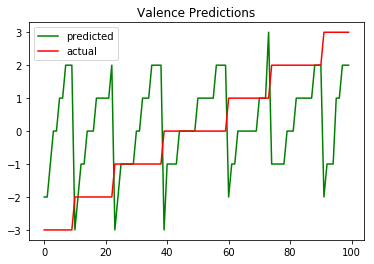

In [41]:
y_new = sort_list(y_pred, y_)

plt.title('Valence Predictions')
plt.plot(y_new, color='green')
plt.plot(sorted(y_), color='red')
plt.legend(['predicted', 'actual'])

plt.savefig('valence.eps', format='eps', dpi=1000)
plt.savefig('valence.png', format='png', dpi=1000)

plt.show()